In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from forex_python.converter import CurrencyRates
from datetime import datetime

In [2]:
print("Welcome to the Financial Instrument Visual Evaluator.")
print("You’ll be prompted to enter tickers, instrument types, sectors, and other data.")
print("We'll collect price and fundamental data and generate charts for evaluation.")

Welcome to the Financial Instrument Visual Evaluator.
You’ll be prompted to enter tickers, instrument types, sectors, and other data.
We'll collect price and fundamental data and generate charts for evaluation.


In [3]:
# Data Input Method Selection
input_method = input("Select input method (1 for CSV, 2 for manual entry): ").strip()

df = pd.DataFrame(columns=["Ticker", "Instrument Type", "Sector", "Region", 
                          "Allocation (%)", "Currency", "Conversion Rate (to TWD)"])

# Option 1: Load from CSV
if input_method == "1":
    csv_file = input("Enter CSV filename (default: Instrument_Allocation_Template.csv): ").strip()
    if not csv_file:
        csv_file = "Instrument_Allocation_Template.csv"
    
    # Check if the CSV file exists
    if not os.path.isfile(csv_file):
        print(f"Error: The file '{csv_file}' does not exist.")
        print("Please create this file with the following columns:")
        print("Ticker, Instrument Type, Sector, Region, Allocation (%), Currency, Conversion Rate (to TWD)")
        print("Example:")
        print("AAPL,Stock,Technology,US,20,USD,")
        print("2330.TW,Stock,Technology,Taiwan,30,TWD,")
    else:
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file)
            print(f"Successfully loaded {len(df)} instruments from {csv_file}")
            
            # Validate required columns
            required_columns = ["Ticker", "Instrument Type", "Sector", "Region", 
                               "Allocation (%)", "Currency"]
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                print(f"Warning: The following required columns are missing: {missing_columns}")
                print("Please update your CSV file with the correct column headers.")
        except Exception as e:
            print(f"Error loading CSV file: {e}")

# Option 2: Manual Entry
elif input_method == "2":
    instruments = []
    print("\nEnter information for each instrument:")
    print("(Enter 'done' for ticker when finished)")
    
    while True:
        ticker = input("\nEnter ticker symbol (or type 'done' to finish): ").strip()
        if ticker.lower() == 'done':
            break
        instrument_type = input("Instrument Type (Stock, ETF, Bond, etc.): ").strip()
        sector = input("Sector (e.g., Technology, Healthcare): ").strip()
        region = input("Region (US, Europe, Asia-Pacific, etc.): ").strip()
        
        while True:
            try:
                allocation = float(input("Allocation percentage (0-100): ").strip())
                break
            except ValueError:
                print("Please enter a valid number.")
        
        currency = input("Currency (USD or TWD): ").strip().upper()

        instruments.append({
            "Ticker": ticker,
            "Instrument Type": instrument_type,
            "Sector": sector,
            "Region": region,
            "Allocation (%)": allocation,
            "Currency": currency,
            "Conversion Rate (to TWD)": None
        })

    df = pd.DataFrame(instruments)
    print(f"Successfully added {len(df)} instruments manually.")

else:
    print("Invalid selection. Please run the program again and select 1 or 2.")


Successfully loaded 8 instruments from Instrument_Allocation_Template.csv


In [4]:
# Option 1: Use a direct API call with requests
def get_exchange_rate(from_currency, to_currency):
    import requests
    try:
        # Using a free currency API (there are many alternatives)
        url = f"https://open.er-api.com/v6/latest/{from_currency}"
        response = requests.get(url)
        data = response.json()
        
        if 'rates' in data and to_currency in data['rates']:
            return data['rates'][to_currency]
        else:
            # Default fallback value if needed
            print(f"Couldn't find conversion rate for {from_currency} to {to_currency}")
            return None
    except Exception as e:
        print(f"Exchange rate API error: {e}")
        return None

# Option 2: Use hardcoded rates for common pairs if API is unreliable
def get_hardcoded_rate(from_currency, to_currency):
    # Example hardcoded rates (update with current rates as needed)
    rates = {
        "USD_TWD": 31.23,  # Update this with a recent USD to TWD rate
        "TWD_USD": 0.032,  # Update this with a recent TWD to USD rate
        # Add other currency pairs as needed
    }
    
    pair_key = f"{from_currency}_{to_currency}"
    if pair_key in rates:
        return rates[pair_key]
    else:
        print(f"No hardcoded rate for {pair_key}")
        return None

# Replace the currency conversion section in your code with:
if not df.empty:
    # First try the API method
    usd_to_twd = get_exchange_rate('USD', 'TWD')
    
    # If API failed, fall back to hardcoded rate
    if usd_to_twd is None:
        usd_to_twd = get_hardcoded_rate('USD', 'TWD')
        print(f"Using hardcoded USD to TWD rate: {usd_to_twd}")
    else:
        print(f"Successfully fetched USD to TWD rate: {usd_to_twd}")
    
    # Apply the rate to the dataframe
    if usd_to_twd is not None:
        df.loc[df['Currency'] == 'USD', 'Conversion Rate (to TWD)'] = usd_to_twd
        df.loc[df['Currency'] == 'TWD', 'Conversion Rate (to TWD)'] = 1.0
    else:
        # Last resort fallback - use 1.0 for everything
        print("Warning: Using fallback conversion rate of 1.0")
        df['Conversion Rate (to TWD)'] = df['Conversion Rate (to TWD)'].fillna(1.0)
else:
    print("No data to process. Please run the program again and add instruments.")

Successfully fetched USD to TWD rate: 30.244297


In [5]:
price_data = {}
for ticker in df['Ticker']:
    try:
        stock = yf.Ticker(ticker)
        hist_daily = stock.history(period="1y", interval="1d")
        hist_weekly = stock.history(period="5y", interval="1wk")
        price_data[ticker] = {"1y_daily": hist_daily, "5y_weekly": hist_weekly}
        print(f"Downloaded data for {ticker}")
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")


Downloaded data for AAPL
Downloaded data for MSFT
Downloaded data for TSLA
Downloaded data for 2330.TW
Downloaded data for GOOGL
Downloaded data for JPM
Downloaded data for JNJ
Downloaded data for VNQ


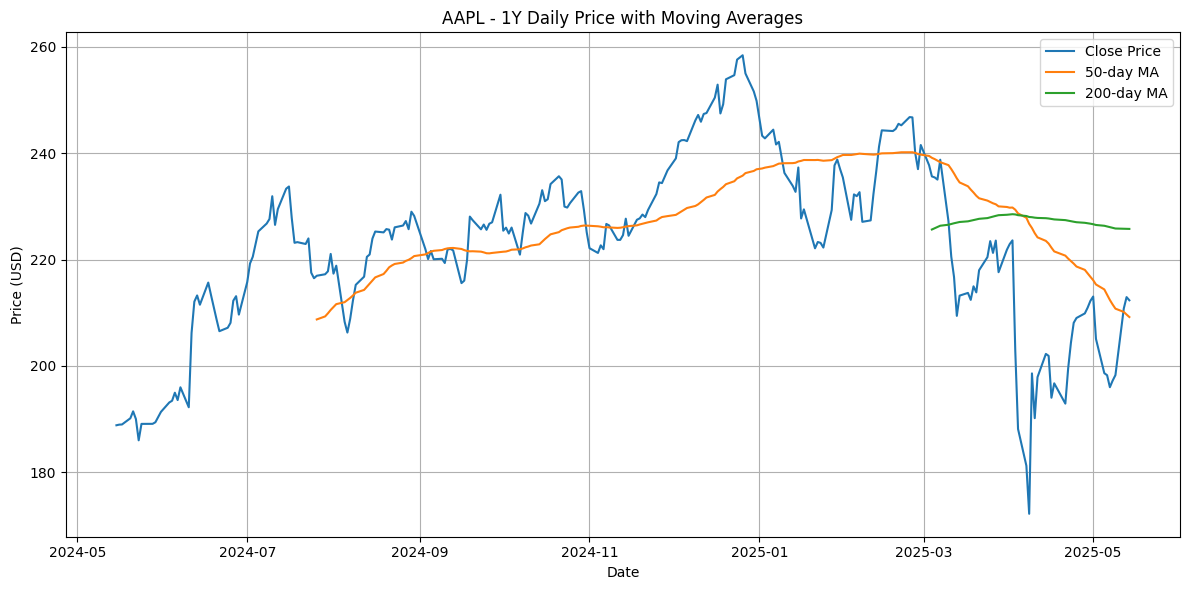

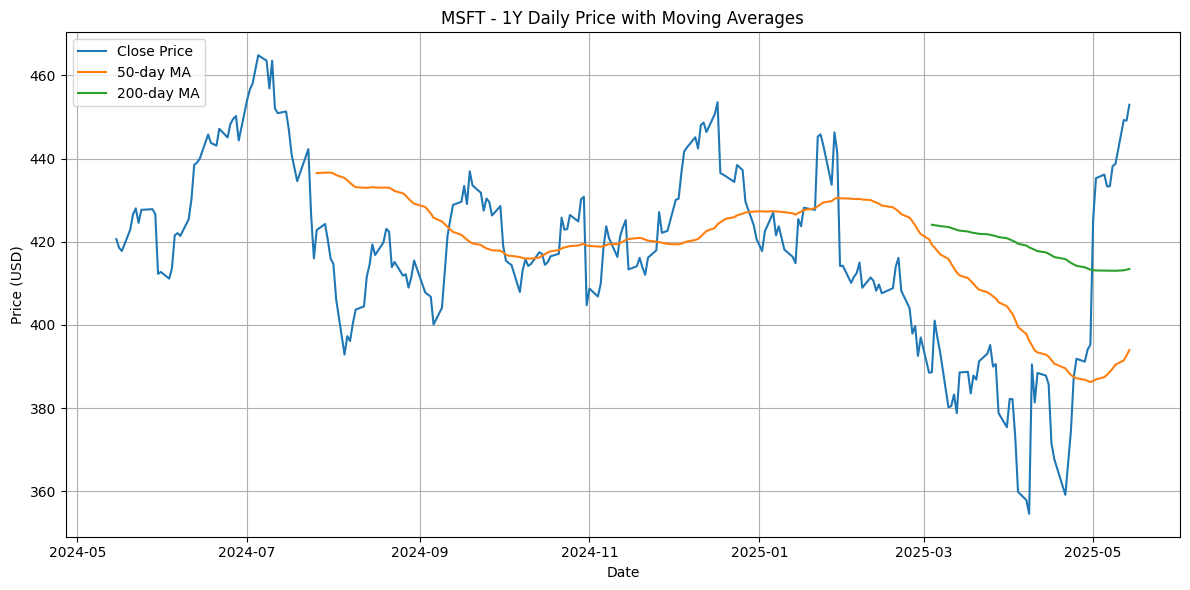

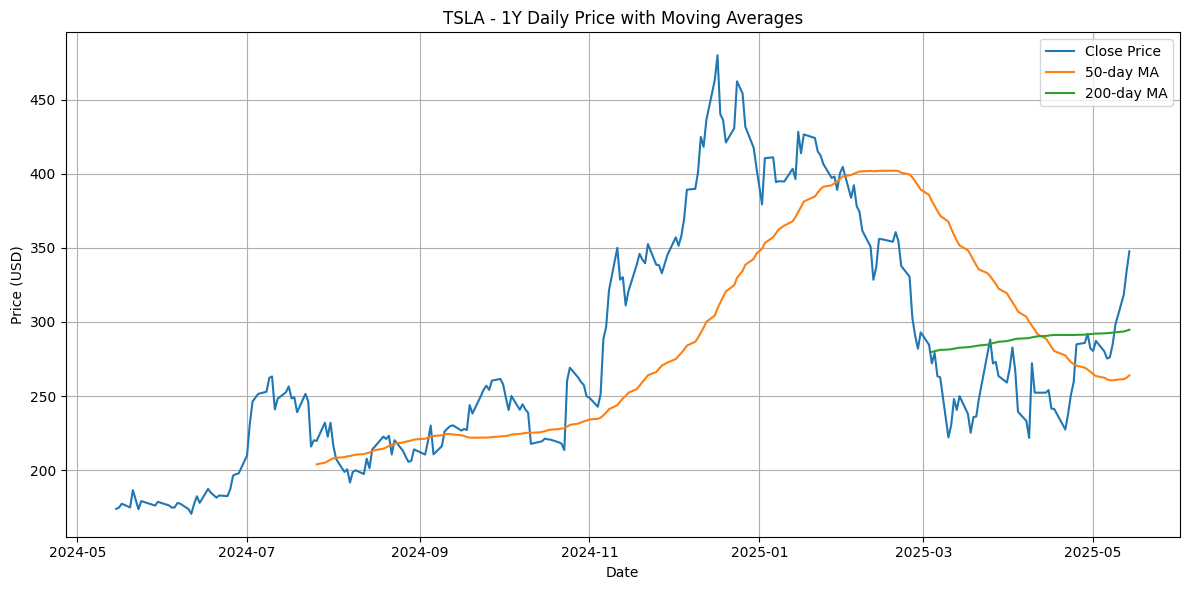

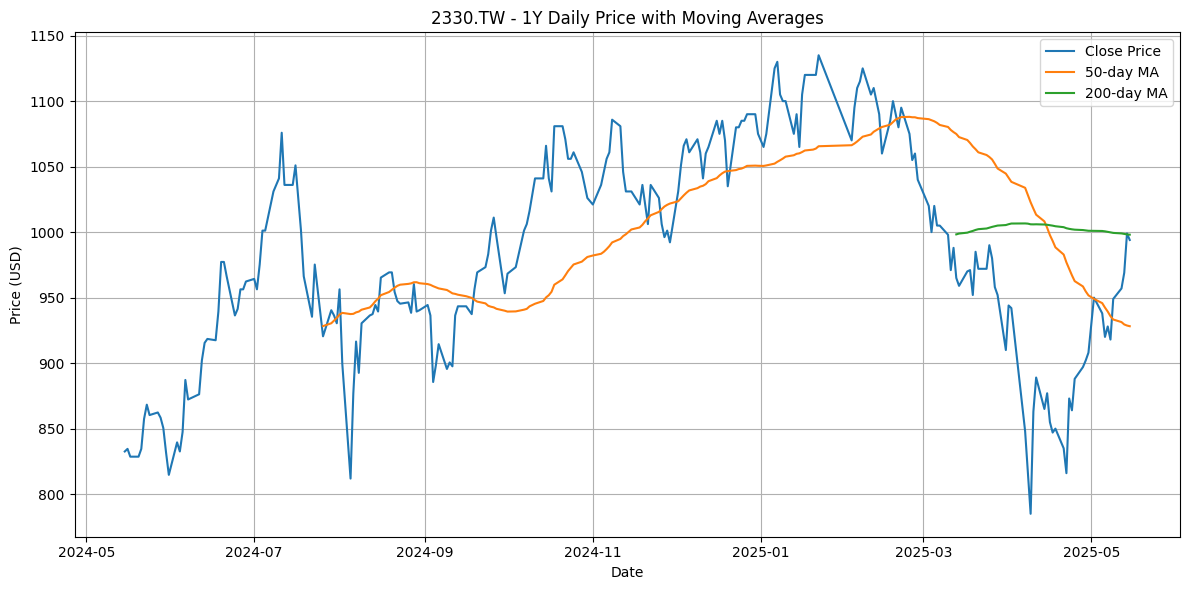

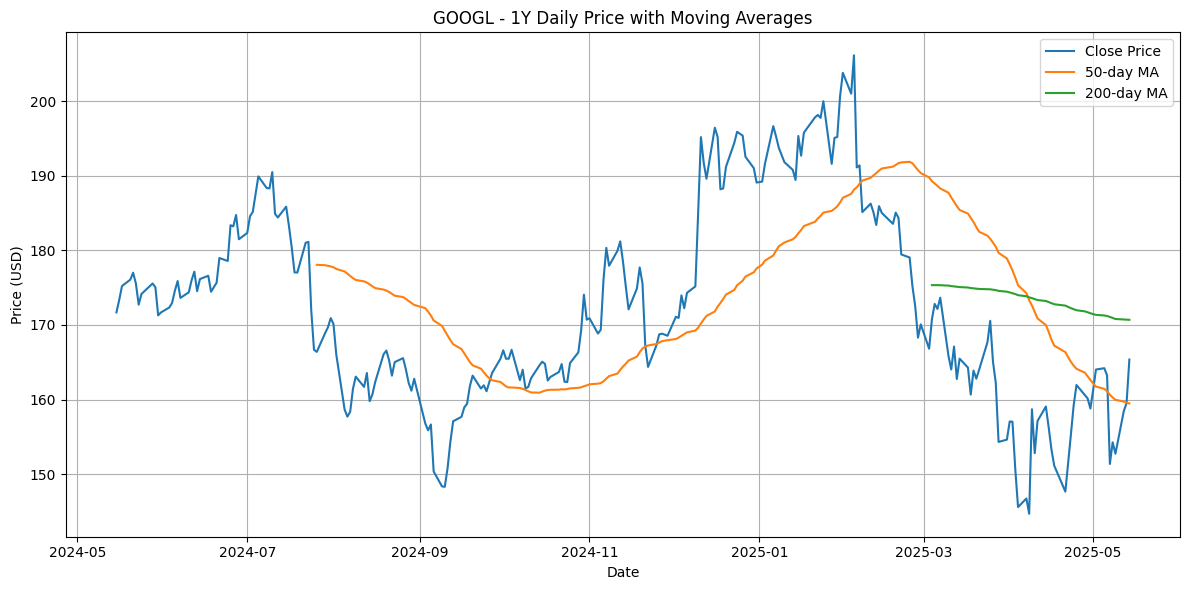

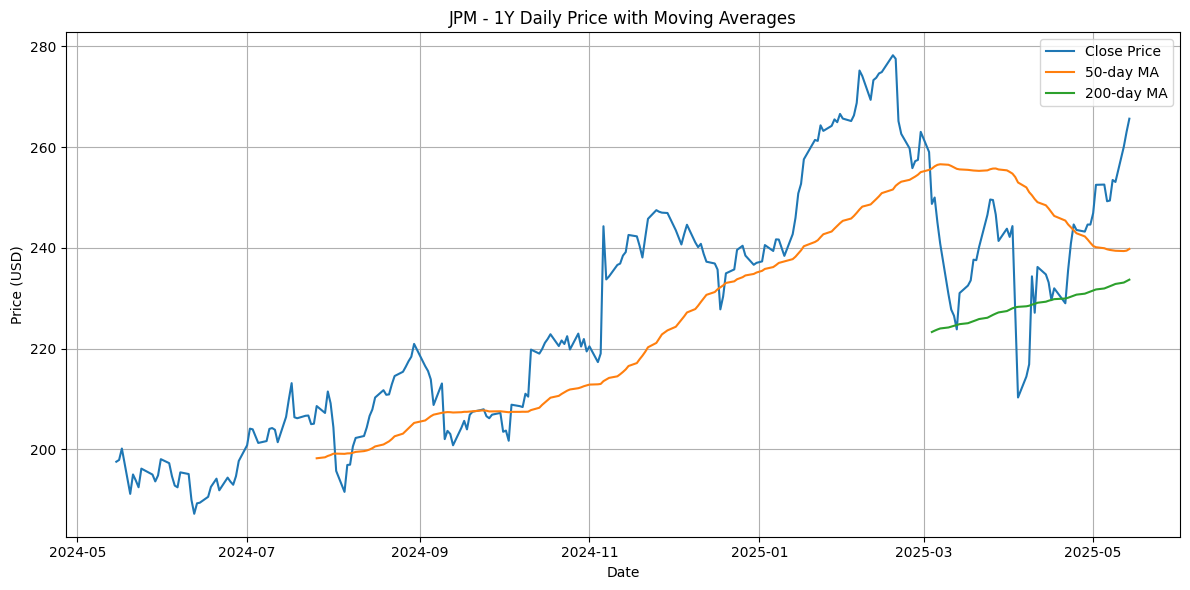

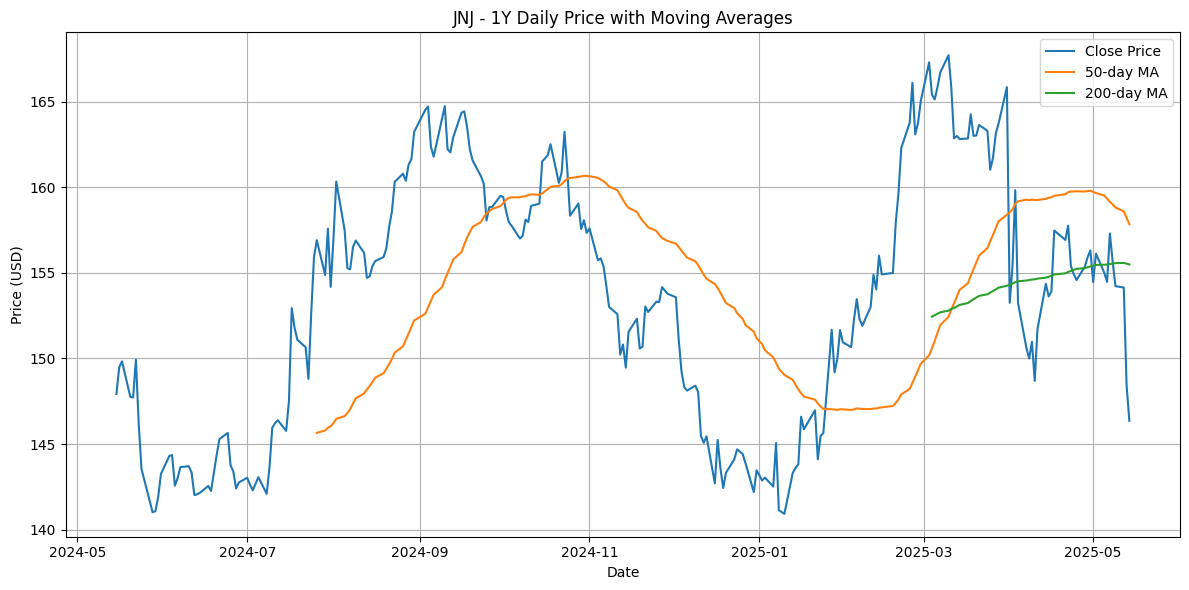

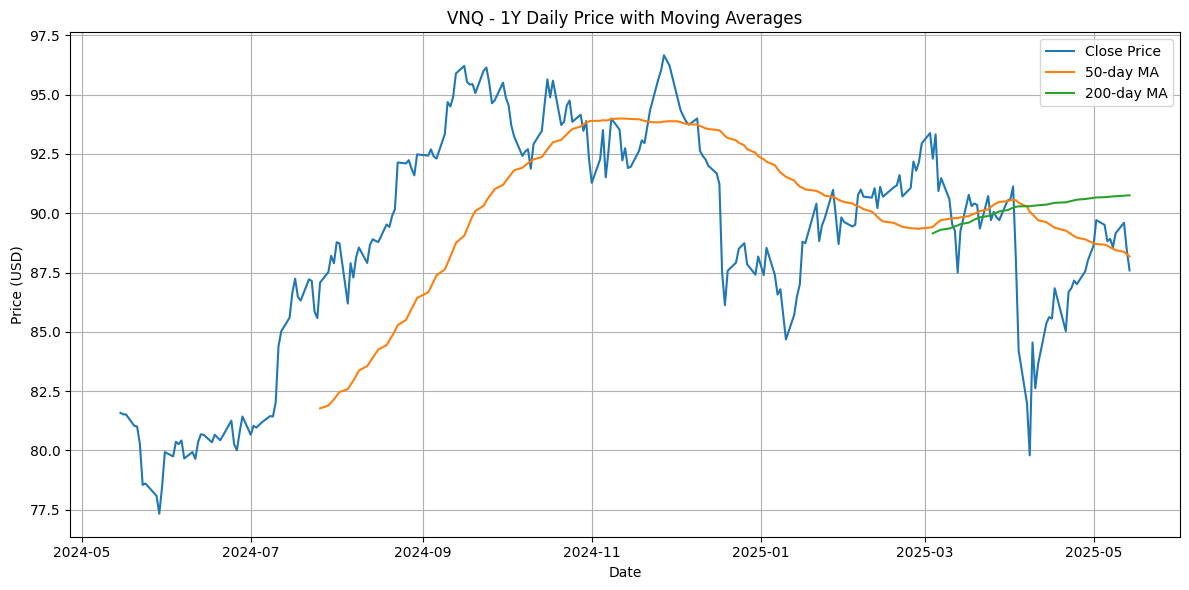

In [6]:
# Plot price + moving averages for all tickers
for ticker in df['Ticker']:
    if ticker not in price_data:
        print(f"Skipping {ticker} due to missing data.")
        continue
    
    data = price_data[ticker]['1y_daily']
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['MA50'], label='50-day MA')
    plt.plot(data['MA200'], label='200-day MA')
    plt.title(f"{ticker} - 1Y Daily Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

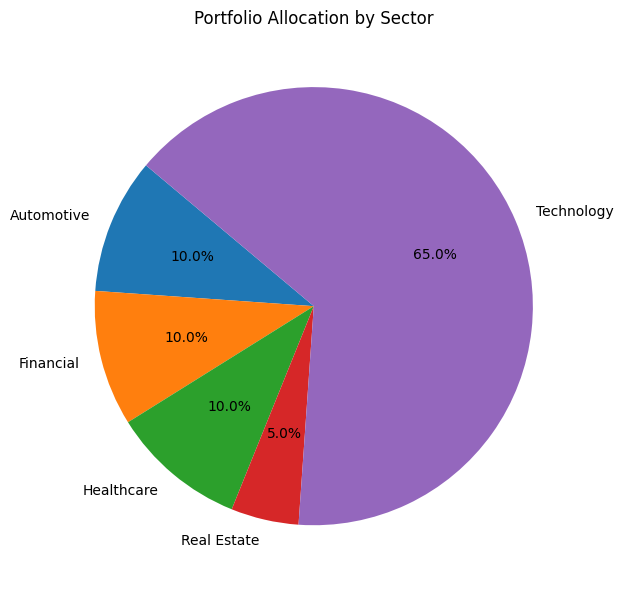

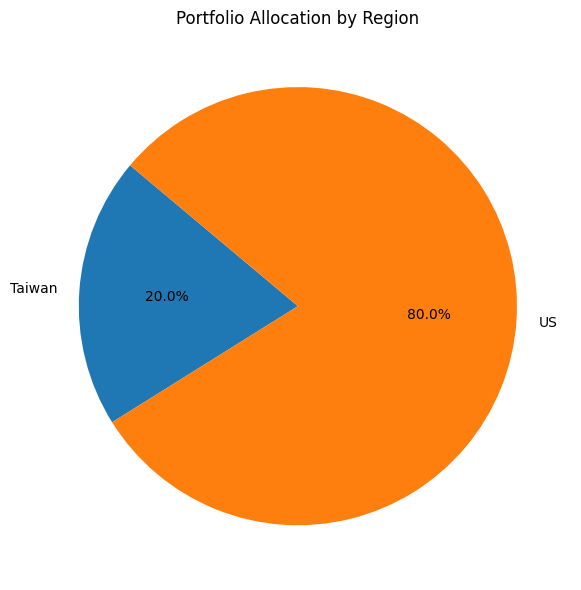

In [7]:
# name this file: sector_and_region_allocation_charts.ipynb
# Copy and paste this into a Jupyter Notebook
# Run each cell sequentially.


# Cell 9: Sector Allocation Pie Chart
plt.figure(figsize=(8, 6))
sector_data = df.groupby('Sector')['Allocation (%)'].sum()
sector_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Sector")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()

# Cell 10: Region Allocation Pie Chart
plt.figure(figsize=(8, 6))
region_data = df.groupby('Region')['Allocation (%)'].sum()
region_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Region")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()


In [8]:
# Copy and paste this into Jupyter Notebook entitled: financial_visual_analysis.ipynb
# Run each cell sequentially.
# When you reach the plotting section, you’ll see a chart for 
# your first entered ticker.

# Cell 11: Build Return DataFrame for Correlation and Risk Analysis
returns_df = pd.DataFrame()

for ticker in df['Ticker']:
    try:
        daily_prices = price_data[ticker]['1y_daily']['Close']
        returns = daily_prices.pct_change().dropna()
        returns_df[ticker] = returns
    except KeyError:
        print(f"Missing data for {ticker}")



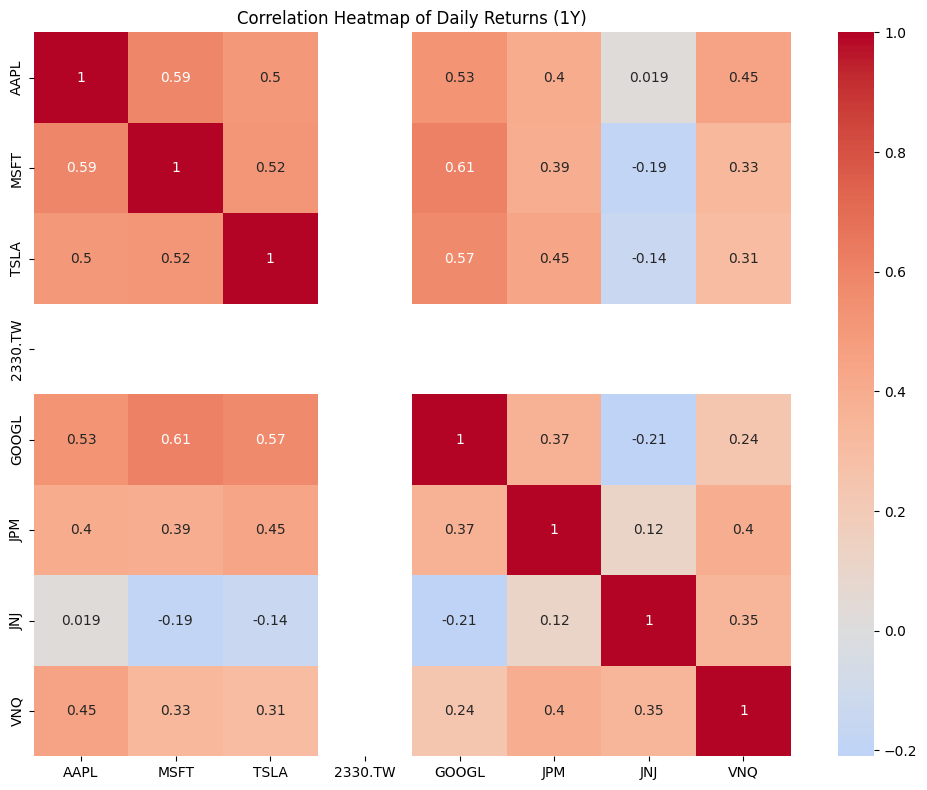

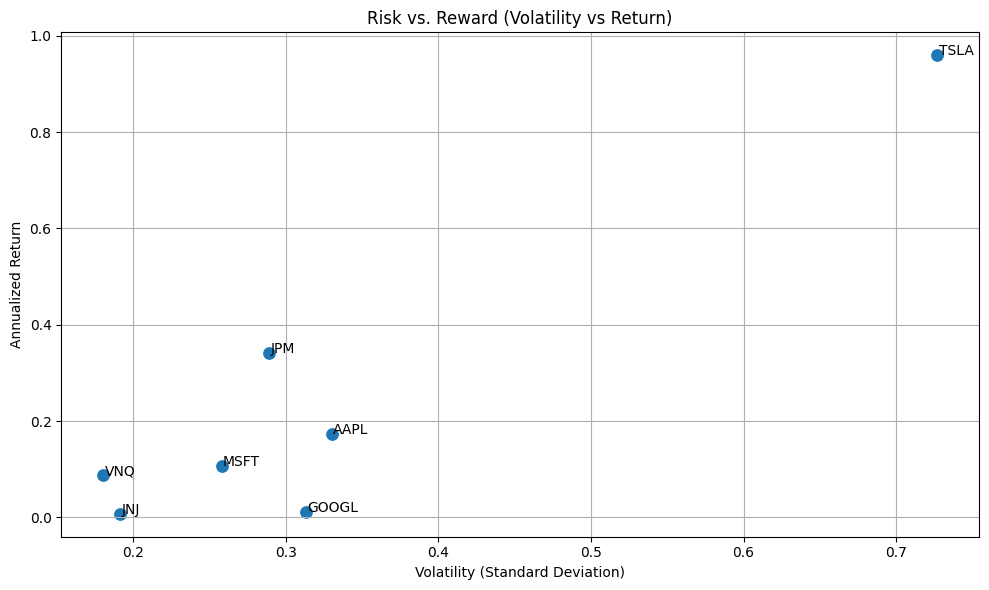

In [9]:
# Cell 12: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = returns_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Daily Returns (1Y)")
plt.tight_layout()
plt.show()

# Cell 13: Risk vs. Reward Scatter Plot
annualized_return = returns_df.mean() * 252  # 252 trading days
annualized_volatility = returns_df.std() * (252 ** 0.5)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=annualized_volatility, y=annualized_return, s=100)

for ticker in returns_df.columns:
    plt.text(annualized_volatility[ticker] + 0.001, annualized_return[ticker], ticker)

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Annualized Return")
plt.title("Risk vs. Reward (Volatility vs Return)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Performance Metrics Calculator
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

In [11]:
# 1. TIME-WEIGHTED RETURN CALCULATOR
def calculate_time_weighted_return(portfolio_data):
    """
    Calculate time-weighted return for a portfolio
    portfolio_data: DataFrame with Date, Portfolio_Value columns
    """
    portfolio_data = portfolio_data.sort_values('Date')
    portfolio_data['Daily_Return'] = portfolio_data['Portfolio_Value'].pct_change()
    portfolio_data['Cumulative_Return'] = (1 + portfolio_data['Daily_Return']).cumprod() - 1
    total_return = portfolio_data['Cumulative_Return'].iloc[-1]
    return total_return


In [12]:
# 2. COMPOUND ANNUAL GROWTH RATE (CAGR)
def calculate_cagr(start_value, end_value, num_years):
    """
    Calculate CAGR given start value, end value, and time period
    """
    cagr = (end_value / start_value) ** (1/num_years) - 1
    return cagr


In [13]:
# 3. ROLLING PERFORMANCE CALCULATOR
def calculate_rolling_performance(portfolio_data, window_days):
    """
    Calculate rolling performance for specified window
    """
    portfolio_data = portfolio_data.sort_values('Date')
    portfolio_data['Rolling_Return'] = portfolio_data['Portfolio_Value'].pct_change(periods=window_days)
    return portfolio_data

# 4. IMPLEMENTATION EXAMPLE
# Create sample portfolio data structure
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
sample_portfolio = pd.DataFrame({
    'Date': dates,
    'Portfolio_Value': np.random.normal(50000, 1000, len(dates)).cumsum() + 50000
})

# Calculate metrics
twr = calculate_time_weighted_return(sample_portfolio)
years = (sample_portfolio['Date'].max() - sample_portfolio['Date'].min()).days / 365.25
cagr = calculate_cagr(sample_portfolio['Portfolio_Value'].iloc[0], 
                      sample_portfolio['Portfolio_Value'].iloc[-1], 
                      years)

print(f"Time-Weighted Return: {twr:.4f}")
print(f"CAGR: {cagr:.4f}")


Time-Weighted Return: 181.9757
CAGR: 182.6297


In [14]:
# Risk Assessment Calculator
import pandas as pd
import numpy as np
from scipy import stats


In [15]:
# 1. BETA CALCULATION
def calculate_beta(portfolio_returns, benchmark_returns):
    """
    Calculate beta (systematic risk) relative to benchmark
    """
    # Align the data
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate covariance and variance
    covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
    benchmark_variance = np.var(benchmark_returns)
    
    beta = covariance / benchmark_variance
    return beta


In [16]:
# 2. VALUE AT RISK (VaR) - HISTORICAL METHOD
def calculate_var(returns, confidence_level=0.05):
    """
    Calculate Value at Risk using historical method
    confidence_level: 0.05 for 95% VaR, 0.01 for 99% VaR
    """
    sorted_returns = np.sort(returns)
    index = int(confidence_level * len(sorted_returns))
    var = abs(sorted_returns[index])
    return var


In [17]:
# 3. SHARPE RATIO
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0.02):
    """
    Calculate Sharpe ratio (risk-adjusted return)
    risk_free_rate: annual risk-free rate (default 2%)
    """
    # Convert annual risk-free rate to daily
    daily_rf = risk_free_rate / 252
    
    # Calculate excess returns
    excess_returns = portfolio_returns - daily_rf
    
    # Calculate Sharpe ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio


In [18]:
# 4. MAXIMUM DRAWDOWN
def calculate_max_drawdown(portfolio_values):
    """
    Calculate maximum drawdown from peak to trough
    """
    # Calculate cumulative maximum
    running_max = np.maximum.accumulate(portfolio_values)
    
    # Calculate drawdown from peak
    drawdown = (portfolio_values - running_max) / running_max
    
    # Find maximum drawdown
    max_drawdown = np.min(drawdown)
    return abs(max_drawdown)


In [19]:
# 5. VOLATILITY CALCULATION
def calculate_volatility(returns, annualize=True):
    """
    Calculate volatility (standard deviation of returns)
    """
    volatility = np.std(returns)
    if annualize:
        volatility = volatility * np.sqrt(252)  # Annualize daily volatility
    return volatility


In [20]:
# 6. IMPLEMENTATION EXAMPLE
# Sample data generation
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
portfolio_returns = pd.Series(np.random.normal(0.0005, 0.01, len(dates)), index=dates)
benchmark_returns = pd.Series(np.random.normal(0.0004, 0.008, len(dates)), index=dates)

# Calculate risk metrics
beta = calculate_beta(portfolio_returns, benchmark_returns)
var_95 = calculate_var(portfolio_returns, 0.05)
sharpe = calculate_sharpe_ratio(portfolio_returns)
volatility = calculate_volatility(portfolio_returns)

print(f"Beta: {beta:.4f}")
print(f"95% VaR: {var_95:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Annualized Volatility: {volatility:.4f}")


Beta: 0.1146
95% VaR: 0.0147
Sharpe Ratio: 1.0007
Annualized Volatility: 0.1628


In [21]:
# Benchmark Comparison and Visualization Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


In [22]:
# 1. BENCHMARK DATA RETRIEVAL
def get_benchmark_data(ticker, start_date, end_date):
    """
    Retrieve benchmark data from Yahoo Finance
    Common benchmarks: '^GSPC' (S&P 500), '^DJI' (Dow), '^IXIC' (NASDAQ)
    """
    benchmark = yf.download(ticker, start=start_date, end=end_date)
    benchmark['Returns'] = benchmark['Adj Close'].pct_change()
    return benchmark


In [23]:
# 2. RELATIVE PERFORMANCE CALCULATION
def calculate_relative_performance(portfolio_returns, benchmark_returns):
    """
    Calculate relative performance metrics
    """
    # Align dates
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate excess returns
    excess_returns = portfolio_returns - benchmark_returns
    
    # Calculate tracking error
    tracking_error = np.std(excess_returns) * np.sqrt(252)
    
    # Calculate information ratio
    information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    
    return {
        'excess_returns': excess_returns,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio
    }


In [24]:
# 3. CUMULATIVE PERFORMANCE COMPARISON
def create_cumulative_performance_chart(portfolio_values, benchmark_values):
    """
    Create cumulative performance comparison chart
    """
    # Normalize to same starting value
    portfolio_normalized = portfolio_values / portfolio_values.iloc[0]
    benchmark_normalized = benchmark_values / benchmark_values.iloc[0]
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_normalized.index, portfolio_normalized.values, 
             label='Portfolio', linewidth=2, color='blue')
    plt.plot(benchmark_normalized.index, benchmark_normalized.values, 
             label='Benchmark', linewidth=2, color='red')
    
    plt.title('Cumulative Performance Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt


In [25]:
# 4. ROLLING PERFORMANCE COMPARISON
def create_rolling_performance_chart(portfolio_returns, benchmark_returns, window=30):
    """
    Create rolling performance comparison chart
    """
    # Calculate rolling returns
    portfolio_rolling = portfolio_returns.rolling(window=window).apply(
        lambda x: (1 + x).prod() - 1) * 100
    benchmark_rolling = benchmark_returns.rolling(window=window).apply(
        lambda x: (1 + x).prod() - 1) * 100
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_rolling.index, portfolio_rolling.values, 
             label=f'Portfolio ({window}-day)', linewidth=2, color='blue')
    plt.plot(benchmark_rolling.index, benchmark_rolling.values, 
             label=f'Benchmark ({window}-day)', linewidth=2, color='red')
    
    plt.title(f'{window}-Day Rolling Returns Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rolling Return (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    return plt


In [26]:
# 5. RISK-RETURN SCATTER PLOT
def create_risk_return_scatter(portfolio_data, benchmark_data):
    """
    Create risk vs return scatter plot
    """
    # Calculate annual returns and volatility
    portfolio_return = portfolio_data['Returns'].mean() * 252
    portfolio_vol = portfolio_data['Returns'].std() * np.sqrt(252)
    benchmark_return = benchmark_data['Returns'].mean() * 252
    benchmark_vol = benchmark_data['Returns'].std() * np.sqrt(252)
    
    plt.figure(figsize=(10, 8))
    plt.scatter([portfolio_vol], [portfolio_return], 
                s=100, color='blue', label='Portfolio', alpha=0.7)
    plt.scatter([benchmark_vol], [benchmark_return], 
                s=100, color='red', label='Benchmark', alpha=0.7)
    
    plt.title('Risk vs Return Analysis', fontsize=16, fontweight='bold')
    plt.xlabel('Annual Volatility', fontsize=12)
    plt.ylabel('Annual Return', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt


In [27]:
# 6. DRAWDOWN COMPARISON
def create_drawdown_comparison(portfolio_values, benchmark_values):
    """
    Create drawdown comparison chart
    """
    # Calculate drawdowns
    portfolio_dd = (portfolio_values / portfolio_values.cummax() - 1) * 100
    benchmark_dd = (benchmark_values / benchmark_values.cummax() - 1) * 100
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_dd.index, portfolio_dd.values, 
             label='Portfolio Drawdown', linewidth=2, color='blue')
    plt.plot(benchmark_dd.index, benchmark_dd.values, 
             label='Benchmark Drawdown', linewidth=2, color='red')
    
    plt.title('Drawdown Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.fill_between(portfolio_dd.index, portfolio_dd.values, 0, 
                     alpha=0.3, color='blue')
    plt.fill_between(benchmark_dd.index, benchmark_dd.values, 0, 
                     alpha=0.3, color='red')
    plt.tight_layout()
    return plt


In [28]:
# 7. PERFORMANCE ATTRIBUTION ANALYSIS
def create_attribution_chart(sectors, sector_weights, sector_returns):
    """
    Create performance attribution chart by sector
    """
    attribution = sector_weights * sector_returns
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(sectors)))
    bars = plt.bar(sectors, attribution, color=colors)
    
    plt.title('Performance Attribution by Sector', fontsize=16, fontweight='bold')
    plt.xlabel('Sector', fontsize=12)
    plt.ylabel('Contribution to Return (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    return plt


Select analysis type:
1. Sample data analysis
2. Real market data analysis
Starting Portfolio Benchmark Analysis...
----------------------------------------
✓ Sample data loaded successfully
✓ Metrics calculated successfully

Generating visualizations...


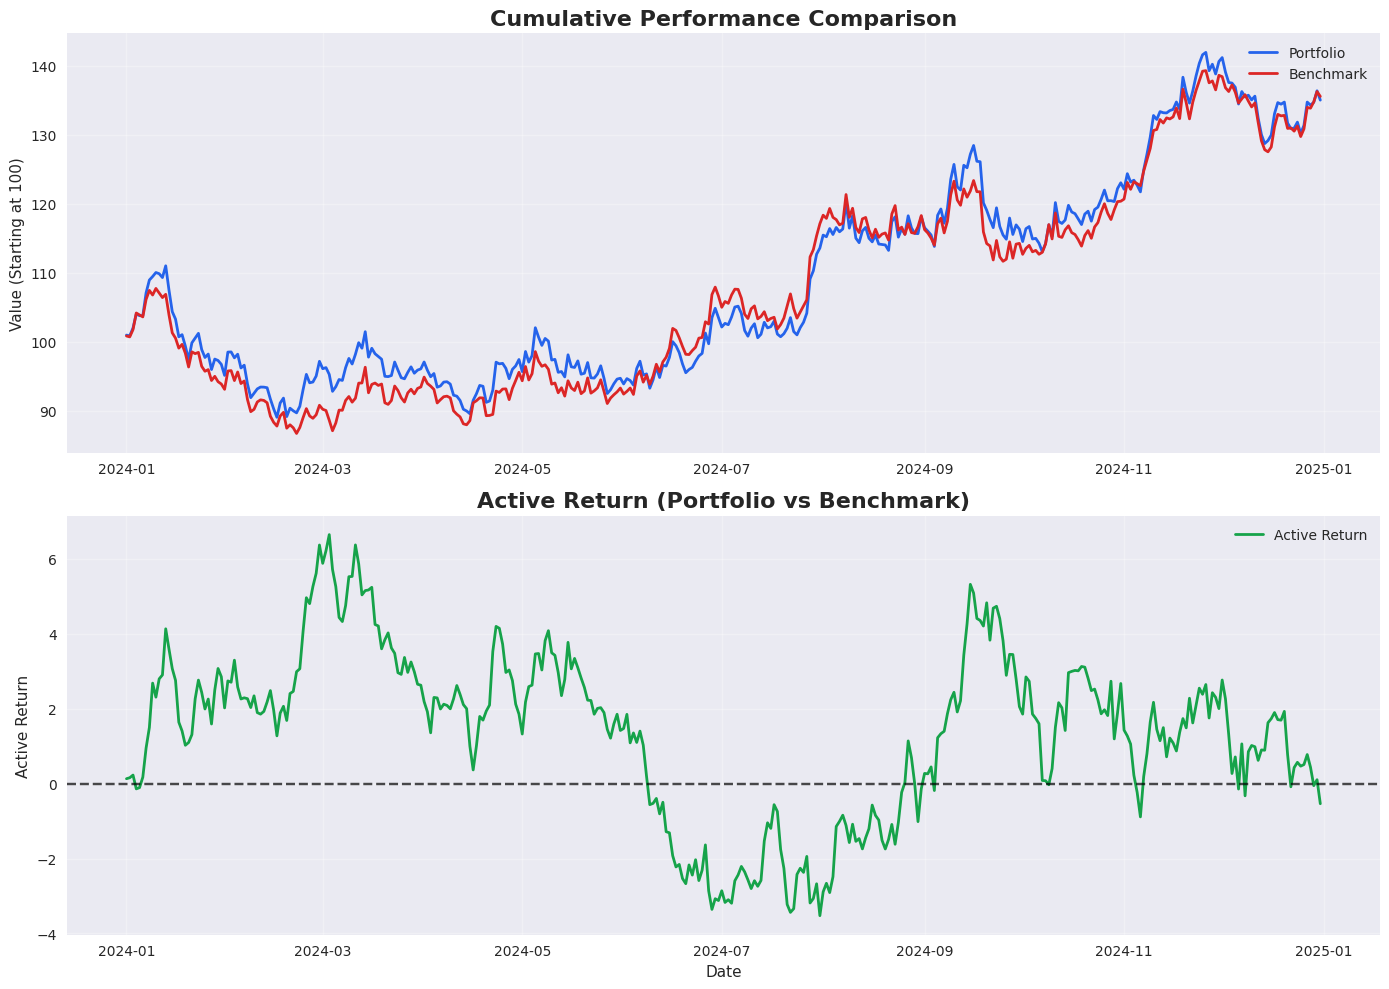

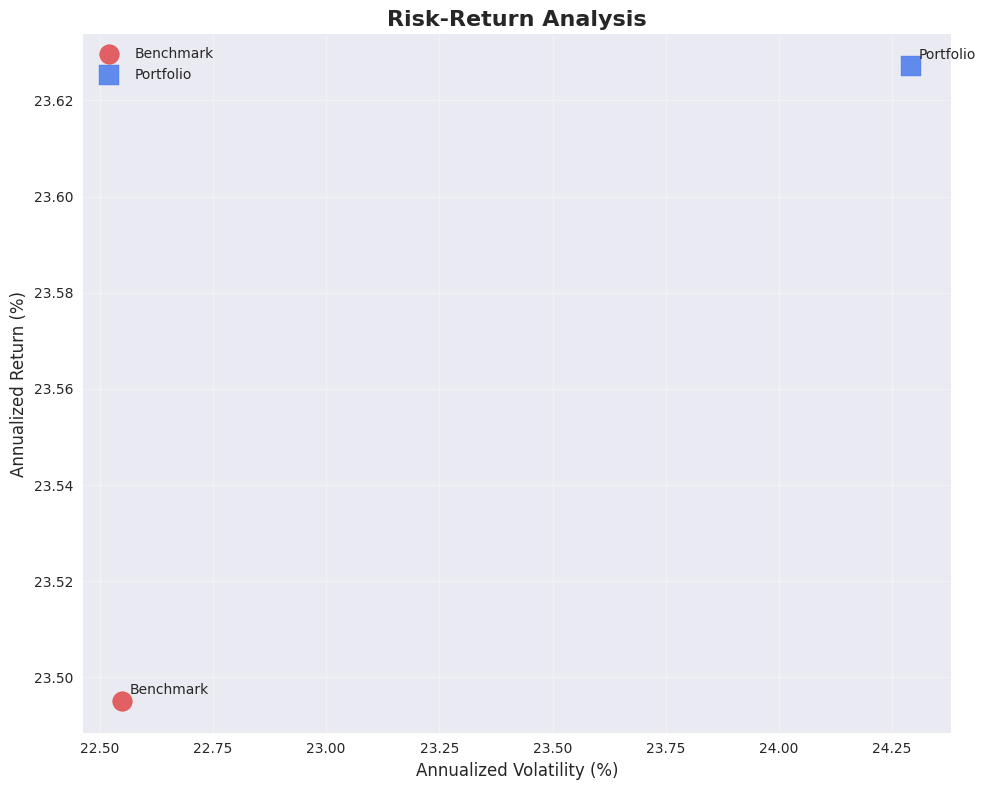

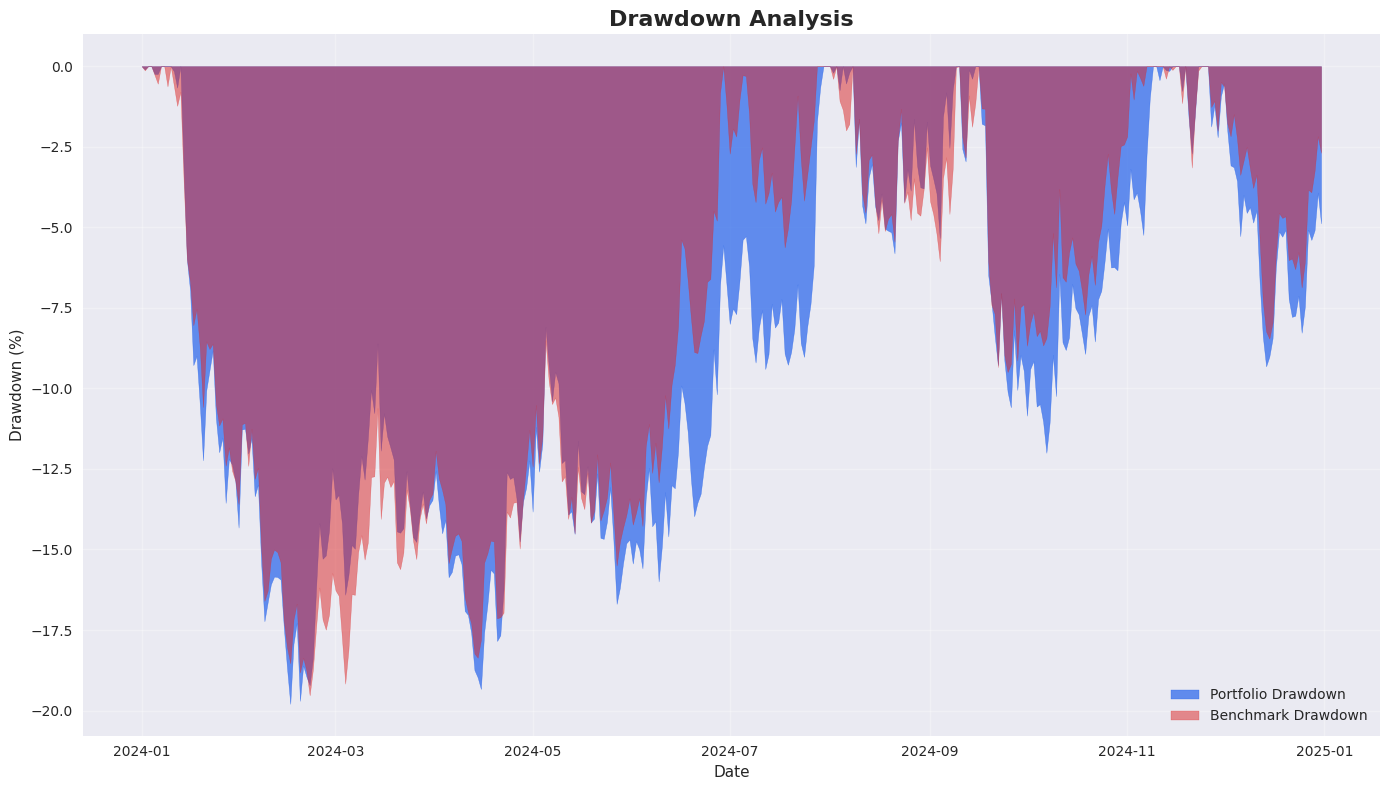

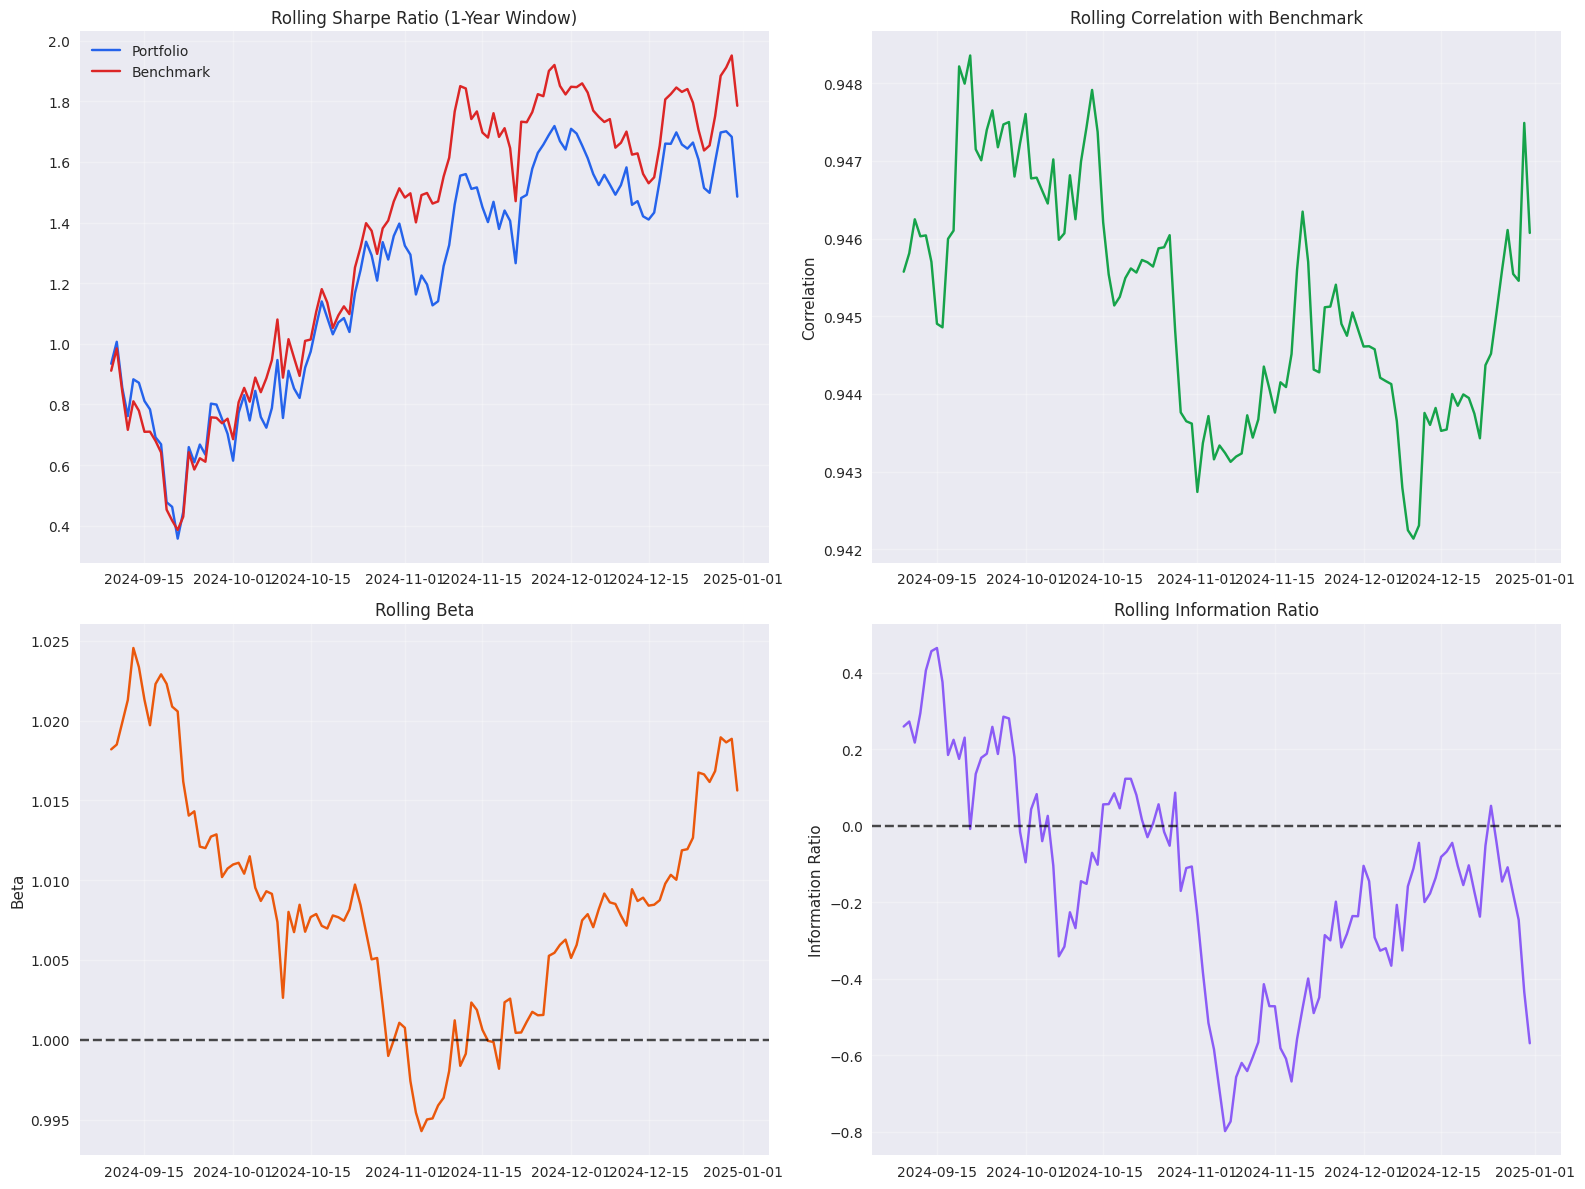


PORTFOLIO BENCHMARK ANALYSIS REPORT
Analysis Date: 2025-05-15 05:45:16
Data Period: 2024-01-01 to 2024-12-31

------------------------------------------------------------
PERFORMANCE METRICS
------------------------------------------------------------
Portfolio Total Return   : 35.04%
Benchmark Total Return   : 35.58%
Active Return            : -0.54%
Portfolio Volatility     : 24.29%
Benchmark Volatility     : 22.55%
Portfolio Sharpe Ratio   : 1.36
Benchmark Sharpe Ratio   : 1.49
Beta                     : 1.02
Alpha                    : -1.16%
Tracking Error           : 8.09%
Information Ratio        : -0.07
Maximum Drawdown         : -19.79%

------------------------------------------------------------
ANALYSIS INSIGHTS
------------------------------------------------------------
⚠ Portfolio underperformed benchmark by 0.54%
⚠ Portfolio had lower risk-adjusted returns (Sharpe: -0.13)
⚠ Negative information ratio - active management destroyed value


Analysis complete! Charts saved 

In [29]:
# Portfolio Benchmark Analysis Tool for GitHub Codespace
# Run: python portfolio_analysis.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

class PortfolioBenchmarkAnalyzer:
    def __init__(self):
        self.portfolio_data = None
        self.benchmark_data = None
        self.metrics = {}
        
    def load_sample_data(self):
        """Create sample portfolio and benchmark data"""
        # Generate sample dates
        dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
        
        # Generate sample portfolio returns (slightly outperforming market)
        np.random.seed(42)
        market_returns = np.random.normal(0.0008, 0.015, len(dates))
        portfolio_returns = market_returns + np.random.normal(0.0002, 0.005, len(dates))
        
        # Calculate cumulative values
        portfolio_values = 100 * (1 + portfolio_returns).cumprod()
        benchmark_values = 100 * (1 + market_returns).cumprod()
        
        self.portfolio_data = pd.DataFrame({
            'Date': dates,
            'Portfolio': portfolio_values,
            'Returns': portfolio_returns
        })
        
        self.benchmark_data = pd.DataFrame({
            'Date': dates,
            'Benchmark': benchmark_values,
            'Returns': market_returns
        })
        
        print("✓ Sample data loaded successfully")
        
    def load_real_data(self, portfolio_tickers, weights, benchmark_ticker='SPY', start_date='2024-01-01'):
        """Load real market data for portfolio and benchmark"""
        try:
            # Download benchmark data
            benchmark_data = yf.download(benchmark_ticker, start=start_date)
            
            # Download portfolio component data
            portfolio_components = {}
            for ticker in portfolio_tickers:
                data = yf.download(ticker, start=start_date)
                portfolio_components[ticker] = data['Adj Close']
            
            # Calculate portfolio value
            portfolio_df = pd.DataFrame(portfolio_components)
            portfolio_returns = portfolio_df.pct_change().fillna(0)
            weighted_returns = (portfolio_returns * weights).sum(axis=1)
            portfolio_values = 100 * (1 + weighted_returns).cumprod()
            
            # Prepare data
            self.portfolio_data = pd.DataFrame({
                'Date': portfolio_values.index,
                'Portfolio': portfolio_values.values,
                'Returns': weighted_returns.values
            })
            
            benchmark_returns = benchmark_data['Adj Close'].pct_change().fillna(0)
            benchmark_values = 100 * (1 + benchmark_returns).cumprod()
            
            self.benchmark_data = pd.DataFrame({
                'Date': benchmark_returns.index,
                'Benchmark': benchmark_values.values,
                'Returns': benchmark_returns.values
            })
            
            print(f"✓ Real data loaded for {len(portfolio_tickers)} securities vs {benchmark_ticker}")
            
        except Exception as e:
            print(f"Error loading real data: {e}")
            print("Falling back to sample data...")
            self.load_sample_data()
    
    def calculate_metrics(self):
        """Calculate comprehensive performance metrics"""
        # Align data
        portfolio_returns = self.portfolio_data['Returns'].dropna()
        benchmark_returns = self.benchmark_data['Returns'].dropna()
        
        # Ensure same length
        min_len = min(len(portfolio_returns), len(benchmark_returns))
        portfolio_returns = portfolio_returns[:min_len]
        benchmark_returns = benchmark_returns[:min_len]
        
        # Calculate metrics
        portfolio_total_return = (self.portfolio_data['Portfolio'].iloc[-1] / 100 - 1) * 100
        benchmark_total_return = (self.benchmark_data['Benchmark'].iloc[-1] / 100 - 1) * 100
        active_return = portfolio_total_return - benchmark_total_return
        
        # Risk metrics
        portfolio_vol = portfolio_returns.std() * np.sqrt(252) * 100
        benchmark_vol = benchmark_returns.std() * np.sqrt(252) * 100
        
        # Sharpe ratio (assuming 2% risk-free rate)
        rf_rate = 0.02
        portfolio_sharpe = (portfolio_total_return/100 - rf_rate) / (portfolio_vol/100)
        benchmark_sharpe = (benchmark_total_return/100 - rf_rate) / (benchmark_vol/100)
        
        # Beta and Alpha
        active_returns = portfolio_returns - benchmark_returns
        tracking_error = active_returns.std() * np.sqrt(252) * 100
        
        # Beta calculation
        covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
        benchmark_variance = np.var(benchmark_returns)
        beta = covariance / benchmark_variance
        
        # Alpha (annualized)
        alpha = (portfolio_total_return/100 - rf_rate) - beta * (benchmark_total_return/100 - rf_rate)
        alpha *= 100
        
        # Information ratio
        info_ratio = active_return / tracking_error if tracking_error > 0 else 0
        
        # Maximum drawdown
        portfolio_values = self.portfolio_data['Portfolio']
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values - peak) / peak
        max_drawdown = drawdown.min() * 100
        
        self.metrics = {
            'Portfolio Total Return': f"{portfolio_total_return:.2f}%",
            'Benchmark Total Return': f"{benchmark_total_return:.2f}%",
            'Active Return': f"{active_return:.2f}%",
            'Portfolio Volatility': f"{portfolio_vol:.2f}%",
            'Benchmark Volatility': f"{benchmark_vol:.2f}%",
            'Portfolio Sharpe Ratio': f"{portfolio_sharpe:.2f}",
            'Benchmark Sharpe Ratio': f"{benchmark_sharpe:.2f}",
            'Beta': f"{beta:.2f}",
            'Alpha': f"{alpha:.2f}%",
            'Tracking Error': f"{tracking_error:.2f}%",
            'Information Ratio': f"{info_ratio:.2f}",
            'Maximum Drawdown': f"{max_drawdown:.2f}%"
        }
        
        print("✓ Metrics calculated successfully")
        
    def create_performance_chart(self):
        """Create performance comparison chart"""
        # Merge data for plotting
        merged_data = pd.merge(self.portfolio_data, self.benchmark_data, on='Date', how='inner')
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Cumulative performance
        ax1.plot(merged_data['Date'], merged_data['Portfolio'], label='Portfolio', linewidth=2, color='#2563eb')
        ax1.plot(merged_data['Date'], merged_data['Benchmark'], label='Benchmark', linewidth=2, color='#dc2626')
        ax1.set_title('Cumulative Performance Comparison', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Value (Starting at 100)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Active return
        active_performance = merged_data['Portfolio'] - merged_data['Benchmark']
        ax2.plot(merged_data['Date'], active_performance, label='Active Return', linewidth=2, color='#16a34a')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax2.set_title('Active Return (Portfolio vs Benchmark)', fontsize=16, fontweight='bold')
        ax2.set_ylabel('Active Return')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_risk_return_scatter(self):
        """Create risk-return scatter plot"""
        # Calculate returns and volatilities for different periods
        portfolio_returns = self.portfolio_data['Returns'].dropna()
        benchmark_returns = self.benchmark_data['Returns'].dropna()
        
        # Annual metrics
        portfolio_annual_return = portfolio_returns.mean() * 252 * 100
        portfolio_annual_vol = portfolio_returns.std() * np.sqrt(252) * 100
        benchmark_annual_return = benchmark_returns.mean() * 252 * 100
        benchmark_annual_vol = benchmark_returns.std() * np.sqrt(252) * 100
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot points
        ax.scatter(benchmark_annual_vol, benchmark_annual_return, s=200, alpha=0.7, 
                  color='#dc2626', label='Benchmark', marker='o')
        ax.scatter(portfolio_annual_vol, portfolio_annual_return, s=200, alpha=0.7, 
                  color='#2563eb', label='Portfolio', marker='s')
        
        # Add labels
        ax.annotate('Benchmark', (benchmark_annual_vol, benchmark_annual_return), 
                   xytext=(5, 5), textcoords='offset points')
        ax.annotate('Portfolio', (portfolio_annual_vol, portfolio_annual_return), 
                   xytext=(5, 5), textcoords='offset points')
        
        ax.set_xlabel('Annualized Volatility (%)', fontsize=12)
        ax.set_ylabel('Annualized Return (%)', fontsize=12)
        ax.set_title('Risk-Return Analysis', fontsize=16, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('risk_return_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_drawdown_analysis(self):
        """Create drawdown analysis chart"""
        # Calculate drawdowns
        portfolio_values = self.portfolio_data['Portfolio']
        benchmark_values = self.benchmark_data['Benchmark']
        
        portfolio_peak = portfolio_values.expanding().max()
        portfolio_drawdown = (portfolio_values - portfolio_peak) / portfolio_peak * 100
        
        benchmark_peak = benchmark_values.expanding().max()
        benchmark_drawdown = (benchmark_values - benchmark_peak) / benchmark_peak * 100
        
        fig, ax = plt.subplots(figsize=(14, 8))
        
        ax.fill_between(self.portfolio_data['Date'], portfolio_drawdown, 0, 
                       alpha=0.7, color='#2563eb', label='Portfolio Drawdown')
        ax.fill_between(self.benchmark_data['Date'], benchmark_drawdown, 0, 
                       alpha=0.5, color='#dc2626', label='Benchmark Drawdown')
        
        ax.set_title('Drawdown Analysis', fontsize=16, fontweight='bold')
        ax.set_ylabel('Drawdown (%)')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('drawdown_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_rolling_metrics(self, window=252):
        """Create rolling metrics analysis"""
        # Calculate rolling metrics
        portfolio_returns = self.portfolio_data['Returns'].dropna()
        benchmark_returns = self.benchmark_data['Returns'].dropna()
        
        # Ensure same length
        min_len = min(len(portfolio_returns), len(benchmark_returns))
        portfolio_returns = portfolio_returns[:min_len]
        benchmark_returns = benchmark_returns[:min_len]
        active_returns = portfolio_returns - benchmark_returns
        
        # Rolling Sharpe ratio
        rolling_sharpe_portfolio = portfolio_returns.rolling(window).apply(
            lambda x: x.mean() / x.std() * np.sqrt(252)) 
        rolling_sharpe_benchmark = benchmark_returns.rolling(window).apply(
            lambda x: x.mean() / x.std() * np.sqrt(252))
        
        # Rolling correlation
        rolling_correlation = portfolio_returns.rolling(window).corr(benchmark_returns)
        
        # Rolling beta
        rolling_beta = portfolio_returns.rolling(window).apply(
            lambda x: np.cov(x, benchmark_returns.iloc[x.index[0]:x.index[-1]+1])[0, 1] / 
                     np.var(benchmark_returns.iloc[x.index[0]:x.index[-1]+1]))
        
        # Rolling information ratio
        rolling_ir = active_returns.rolling(window).apply(
            lambda x: x.mean() / x.std() * np.sqrt(252))
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Rolling Sharpe ratios
        ax1.plot(self.portfolio_data['Date'][window:], rolling_sharpe_portfolio[window:], 
                label='Portfolio', color='#2563eb')
        ax1.plot(self.portfolio_data['Date'][window:], rolling_sharpe_benchmark[window:], 
                label='Benchmark', color='#dc2626')
        ax1.set_title('Rolling Sharpe Ratio (1-Year Window)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Rolling correlation
        ax2.plot(self.portfolio_data['Date'][window:], rolling_correlation[window:], 
                color='#16a34a')
        ax2.set_title('Rolling Correlation with Benchmark')
        ax2.set_ylabel('Correlation')
        ax2.grid(True, alpha=0.3)
        
        # Rolling beta
        ax3.plot(self.portfolio_data['Date'][window:], rolling_beta[window:], 
                color='#ea580c')
        ax3.axhline(y=1, color='black', linestyle='--', alpha=0.7)
        ax3.set_title('Rolling Beta')
        ax3.set_ylabel('Beta')
        ax3.grid(True, alpha=0.3)
        
        # Rolling information ratio
        ax4.plot(self.portfolio_data['Date'][window:], rolling_ir[window:], 
                color='#8b5cf6')
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax4.set_title('Rolling Information Ratio')
        ax4.set_ylabel('Information Ratio')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('rolling_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def print_summary_report(self):
        """Print comprehensive summary report"""
        print("\n" + "="*60)
        print("PORTFOLIO BENCHMARK ANALYSIS REPORT")
        print("="*60)
        print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Data Period: {self.portfolio_data['Date'].min().strftime('%Y-%m-%d')} to {self.portfolio_data['Date'].max().strftime('%Y-%m-%d')}")
        print("\n" + "-"*60)
        print("PERFORMANCE METRICS")
        print("-"*60)
        
        for metric, value in self.metrics.items():
            print(f"{metric:<25}: {value}")
        
        print("\n" + "-"*60)
        print("ANALYSIS INSIGHTS")
        print("-"*60)
        
        # Generate insights based on metrics
        active_return = float(self.metrics['Active Return'].strip('%'))
        sharpe_diff = float(self.metrics['Portfolio Sharpe Ratio']) - float(self.metrics['Benchmark Sharpe Ratio'])
        info_ratio = float(self.metrics['Information Ratio'])
        
        if active_return > 0:
            print(f"✓ Portfolio outperformed benchmark by {abs(active_return):.2f}%")
        else:
            print(f"⚠ Portfolio underperformed benchmark by {abs(active_return):.2f}%")
            
        if sharpe_diff > 0:
            print(f"✓ Portfolio achieved better risk-adjusted returns (Sharpe: +{sharpe_diff:.2f})")
        else:
            print(f"⚠ Portfolio had lower risk-adjusted returns (Sharpe: {sharpe_diff:.2f})")
            
        if info_ratio > 0.5:
            print("✓ Strong information ratio indicates effective active management")
        elif info_ratio > 0:
            print("⚠ Moderate information ratio - room for improvement in active management")
        else:
            print("⚠ Negative information ratio - active management destroyed value")
        
        print("\n" + "="*60)
        
    def run_analysis(self, use_real_data=False, portfolio_tickers=None, weights=None, benchmark='SPY'):
        """Run complete benchmark analysis"""
        print("Starting Portfolio Benchmark Analysis...")
        print("-" * 40)
        
        # Load data
        if use_real_data and portfolio_tickers and weights:
            self.load_real_data(portfolio_tickers, weights, benchmark)
        else:
            self.load_sample_data()
        
        # Calculate metrics
        self.calculate_metrics()
        
        # Generate visualizations
        print("\nGenerating visualizations...")
        self.create_performance_chart()
        self.create_risk_return_scatter()
        self.create_drawdown_analysis()
        self.create_rolling_metrics()
        
        # Print summary
        self.print_summary_report()
        
        print("\nAnalysis complete! Charts saved as PNG files.")
        print("Files saved:")
        print("- performance_comparison.png")
        print("- risk_return_analysis.png")
        print("- drawdown_analysis.png")
        print("- rolling_metrics.png")

def main():
    """Main function to run the analysis"""
    analyzer = PortfolioBenchmarkAnalyzer()
    
    # Option 1: Use sample data
    print("Select analysis type:")
    print("1. Sample data analysis")
    print("2. Real market data analysis")
    
    choice = input("Enter choice (1 or 2): ").strip()
    
    if choice == '2':
        # Option 2: Use real data
        print("\nReal Data Analysis Setup")
        print("Enter portfolio tickers (comma-separated):")
        tickers_input = input("Example: AAPL,GOOGL,MSFT,TSLA: ").strip()
        tickers = [t.strip().upper() for t in tickers_input.split(',') if t.strip()]
        
        print("Enter weights (comma-separated, should sum to 1):")
        weights_input = input("Example: 0.3,0.25,0.25,0.2: ").strip()
        weights = [float(w.strip()) for w in weights_input.split(',') if w.strip()]
        
        benchmark = input("Enter benchmark ticker (default SPY): ").strip().upper() or 'SPY'
        
        if len(tickers) != len(weights):
            print("Error: Number of tickers must match number of weights")
            print("Using sample data instead...")
            analyzer.run_analysis()
        else:
            analyzer.run_analysis(use_real_data=True, portfolio_tickers=tickers, 
                                 weights=weights, benchmark=benchmark)
    else:
        # Use sample data
        analyzer.run_analysis()

if __name__ == "__main__":
    main()

In [30]:
import React, { useState, useEffect, useMemo } from 'react';
import { LineChart, Line, XAxis, YAxis, CartesianGrid, Tooltip, Legend, BarChart, Bar, ScatterChart, Scatter, PieChart, Pie, Cell, RadarChart, PolarGrid, PolarAngleAxis, PolarRadiusAxis, Radar, ResponsiveContainer } from 'recharts';

const PortfolioBenchmarkVisualizer = () => {
  // Sample data - in real implementation, this would come from your spreadsheet/database
  const [portfolioData, setPortfolioData] = useState([
    { date: '2024-01-01', portfolio: 100, sp500: 100, nasdaq: 100, benchmark: 100 },
    { date: '2024-02-01', portfolio: 103, sp500: 102, nasdaq: 105, benchmark: 102.5 },
    { date: '2024-03-01', portfolio: 107, sp500: 105, nasdaq: 108, benchmark: 106 },
    { date: '2024-04-01', portfolio: 112, sp500: 108, nasdaq: 111, benchmark: 109 },
    { date: '2024-05-01', portfolio: 115, sp500: 110, nasdaq: 114, benchmark: 112 },
    { date: '2024-06-01', portfolio: 118, sp500: 113, nasdaq: 116, benchmark: 114.5 },
    { date: '2024-07-01', portfolio: 122, sp500: 115, nasdaq: 119, benchmark: 117 },
    { date: '2024-08-01', portfolio: 125, sp500: 118, nasdaq: 122, benchmark: 120 },
    { date: '2024-09-01', portfolio: 128, sp500: 121, nasdaq: 125, benchmark: 123 },
    { date: '2024-10-01', portfolio: 131, sp500: 124, nasdaq: 128, benchmark: 126 },
    { date: '2024-11-01', portfolio: 134, sp500: 127, nasdaq: 131, benchmark: 129 },
    { date: '2024-12-01', portfolio: 137, sp500: 130, nasdaq: 134, benchmark: 132 }
  ]);

  // Risk-Return data for scatter plot
  const riskReturnData = [
    { name: 'Portfolio', return: 37, risk: 15, size: 100 },
    { name: 'S&P 500', return: 30, risk: 12, size: 80 },
    { name: 'NASDAQ', return: 34, risk: 18, size: 85 },
    { name: 'Custom Benchmark', return: 32, risk: 14, size: 90 }
  ];

  // Performance attribution data
  const attributionData = [
    { factor: 'Security Selection', value: 4.2 },
    { factor: 'Asset Allocation', value: 2.1 },
    { factor: 'Currency', value: 0.8 },
    { factor: 'Interaction', value: -0.3 },
    { factor: 'Fees', value: -1.5 }
  ];

  // Sector allocation comparison
  const sectorData = [
    { sector: 'Technology', portfolio: 35, benchmark: 28 },
    { sector: 'Healthcare', portfolio: 15, benchmark: 13 },
    { sector: 'Financial', portfolio: 12, benchmark: 15 },
    { sector: 'Consumer Disc.', portfolio: 10, benchmark: 12 },
    { sector: 'Energy', portfolio: 8, benchmark: 10 },
    { sector: 'Industrial', portfolio: 7, benchmark: 8 },
    { sector: 'Materials', portfolio: 5, benchmark: 6 },
    { sector: 'Utilities', portfolio: 4, benchmark: 4 },
    { sector: 'Real Estate', portfolio: 4, benchmark: 4 }
  ];

  // Rolling performance data
  const rollingData = [
    { period: '1M', portfolio: 2.5, benchmark: 2.1 },
    { period: '3M', portfolio: 7.8, benchmark: 6.9 },
    { period: '6M', portfolio: 15.2, benchmark: 13.5 },
    { period: '1Y', portfolio: 37.0, benchmark: 32.0 },
    { period: '3Y', portfolio: 45.2, benchmark: 41.8 },
    { period: '5Y', portfolio: 58.9, benchmark: 52.3 }
  ];

  // Drawdown analysis
  const drawdownData = [
    { date: '2024-01-01', portfolio: 0, benchmark: 0 },
    { date: '2024-02-01', portfolio: -2.1, benchmark: -1.8 },
    { date: '2024-03-01', portfolio: -0.8, benchmark: -1.2 },
    { date: '2024-04-01', portfolio: 0, benchmark: 0 },
    { date: '2024-05-01', portfolio: -1.5, benchmark: -2.1 },
    { date: '2024-06-01', portfolio: 0, benchmark: 0 },
    { date: '2024-07-01', portfolio: -3.2, benchmark: -2.8 },
    { date: '2024-08-01', portfolio: -1.1, benchmark: -1.5 },
    { date: '2024-09-01', portfolio: 0, benchmark: 0 },
    { date: '2024-10-01', portfolio: -2.8, benchmark: -3.1 },
    { date: '2024-11-01', portfolio: -0.5, benchmark: -1.0 },
    { date: '2024-12-01', portfolio: 0, benchmark: 0 }
  ];

  const [selectedBenchmark, setSelectedBenchmark] = useState('sp500');
  const [viewMode, setViewMode] = useState('cumulative');

  // Calculate key metrics
  const portfolioMetrics = useMemo(() => {
    const finalPortfolio = portfolioData[portfolioData.length - 1].portfolio;
    const finalBenchmark = portfolioData[portfolioData.length - 1][selectedBenchmark];
    const totalReturn = ((finalPortfolio - 100) / 100 * 100).toFixed(2);
    const benchmarkReturn = ((finalBenchmark - 100) / 100 * 100).toFixed(2);
    const activeReturn = (totalReturn - benchmarkReturn).toFixed(2);
    
    return {
      totalReturn,
      benchmarkReturn,
      activeReturn,
      sharpeRatio: '1.45',
      informationRatio: '0.82',
      trackingError: '3.2%',
      beta: '1.08',
      alpha: '2.1%'
    };
  }, [portfolioData, selectedBenchmark]);

  // Colors for charts
  const colors = {
    portfolio: '#2563eb',
    sp500: '#dc2626',
    nasdaq: '#16a34a',
    benchmark: '#ea580c',
    positive: '#10b981',
    negative: '#ef4444'
  };

  return (
    <div className="p-6 bg-gray-50 min-h-screen">
      <div className="max-w-7xl mx-auto">
        {/* Header */}
        <div className="mb-8">
          <h1 className="text-3xl font-bold text-gray-900 mb-2">
            Portfolio Benchmark Comparison & Visualization Tools
          </h1>
          <p className="text-lg text-gray-600">
            Comprehensive analysis and comparison of portfolio performance against selected benchmarks
          </p>
        </div>

        {/* Control Panel */}
        <div className="bg-white rounded-lg shadow-sm p-6 mb-6">
          <div className="flex flex-wrap gap-4 mb-4">
            <div>
              <label className="block text-sm font-medium text-gray-700 mb-2">
                Select Benchmark
              </label>
              <select
                value={selectedBenchmark}
                onChange={(e) => setSelectedBenchmark(e.target.value)}
                className="px-3 py-2 border border-gray-300 rounded-md focus:ring-2 focus:ring-blue-500"
              >
                <option value="sp500">S&P 500</option>
                <option value="nasdaq">NASDAQ</option>
                <option value="benchmark">Custom Benchmark</option>
              </select>
            </div>
            <div>
              <label className="block text-sm font-medium text-gray-700 mb-2">
                View Mode
              </label>
              <select
                value={viewMode}
                onChange={(e) => setViewMode(e.target.value)}
                className="px-3 py-2 border border-gray-300 rounded-md focus:ring-2 focus:ring-blue-500"
              >
                <option value="cumulative">Cumulative Returns</option>
                <option value="relative">Relative Performance</option>
                <option value="drawdown">Drawdown Analysis</option>
              </select>
            </div>
          </div>

          {/* Key Metrics */}
          <div className="grid grid-cols-2 md:grid-cols-4 lg:grid-cols-8 gap-4">
            <div className="bg-blue-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Portfolio Return</p>
              <p className="text-lg font-semibold text-blue-600">{portfolioMetrics.totalReturn}%</p>
            </div>
            <div className="bg-gray-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Benchmark Return</p>
              <p className="text-lg font-semibold text-gray-600">{portfolioMetrics.benchmarkReturn}%</p>
            </div>
            <div className="bg-green-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Active Return</p>
              <p className="text-lg font-semibold text-green-600">+{portfolioMetrics.activeReturn}%</p>
            </div>
            <div className="bg-purple-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Sharpe Ratio</p>
              <p className="text-lg font-semibold text-purple-600">{portfolioMetrics.sharpeRatio}</p>
            </div>
            <div className="bg-orange-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Info Ratio</p>
              <p className="text-lg font-semibold text-orange-600">{portfolioMetrics.informationRatio}</p>
            </div>
            <div className="bg-red-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Tracking Error</p>
              <p className="text-lg font-semibold text-red-600">{portfolioMetrics.trackingError}</p>
            </div>
            <div className="bg-indigo-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Beta</p>
              <p className="text-lg font-semibold text-indigo-600">{portfolioMetrics.beta}</p>
            </div>
            <div className="bg-pink-50 p-3 rounded-lg">
              <p className="text-xs text-gray-600">Alpha</p>
              <p className="text-lg font-semibold text-pink-600">{portfolioMetrics.alpha}</p>
            </div>
          </div>
        </div>

        {/* Main Charts Grid */}
        <div className="grid grid-cols-1 lg:grid-cols-2 gap-6 mb-6">
          {/* Performance Chart */}
          <div className="bg-white rounded-lg shadow-sm p-6">
            <h3 className="text-lg font-semibold mb-4">
              {viewMode === 'cumulative' ? 'Cumulative Performance' : 
               viewMode === 'relative' ? 'Relative Performance' : 'Drawdown Analysis'}
            </h3>
            <ResponsiveContainer width="100%" height={300}>
              {viewMode === 'drawdown' ? (
                <LineChart data={drawdownData}>
                  <CartesianGrid strokeDasharray="3 3" />
                  <XAxis dataKey="date" tickFormatter={(value) => new Date(value).toLocaleDateString()} />
                  <YAxis />
                  <Tooltip 
                    labelFormatter={(value) => new Date(value).toLocaleDateString()}
                    formatter={(value, name) => [`${value}%`, name]}
                  />
                  <Legend />
                  <Line type="monotone" dataKey="portfolio" stroke={colors.portfolio} strokeWidth={2} name="Portfolio Drawdown" />
                  <Line type="monotone" dataKey="benchmark" stroke={colors.benchmark} strokeWidth={2} name="Benchmark Drawdown" />
                </LineChart>
              ) : (
                <LineChart data={portfolioData}>
                  <CartesianGrid strokeDasharray="3 3" />
                  <XAxis dataKey="date" tickFormatter={(value) => new Date(value).toLocaleDateString()} />
                  <YAxis />
                  <Tooltip 
                    labelFormatter={(value) => new Date(value).toLocaleDateString()}
                    formatter={(value, name) => [value.toFixed(2), name]}
                  />
                  <Legend />
                  <Line type="monotone" dataKey="portfolio" stroke={colors.portfolio} strokeWidth={3} name="Portfolio" />
                  <Line type="monotone" dataKey={selectedBenchmark} stroke={colors.benchmark} strokeWidth={2} name="Benchmark" />
                </LineChart>
              )}
            </ResponsiveContainer>
          </div>

          {/* Risk-Return Scatter */}
          <div className="bg-white rounded-lg shadow-sm p-6">
            <h3 className="text-lg font-semibold mb-4">Risk-Return Analysis</h3>
            <ResponsiveContainer width="100%" height={300}>
              <ScatterChart>
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis type="number" dataKey="risk" name="Risk (Volatility)" domain={[0, 25]} label={{ value: 'Risk (%)', position: 'insideBottom', offset: -5 }} />
                <YAxis type="number" dataKey="return" name="Return" domain={[0, 45]} label={{ value: 'Return (%)', angle: -90, position: 'insideLeft' }} />
                <Tooltip cursor={{ strokeDasharray: '3 3' }} formatter={(value, name) => [`${value}%`, name]} />
                <Scatter data={riskReturnData} fill={colors.portfolio}>
                  {riskReturnData.map((entry, index) => (
                    <Cell key={`cell-${index}`} fill={index === 0 ? colors.portfolio : colors.benchmark} />
                  ))}
                </Scatter>
              </ScatterChart>
            </ResponsiveContainer>
          </div>
        </div>

        {/* Secondary Charts Grid */}
        <div className="grid grid-cols-1 lg:grid-cols-3 gap-6 mb-6">
          {/* Performance Attribution */}
          <div className="bg-white rounded-lg shadow-sm p-6">
            <h3 className="text-lg font-semibold mb-4">Performance Attribution</h3>
            <ResponsiveContainer width="100%" height={250}>
              <BarChart data={attributionData} layout="horizontal">
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis type="number" />
                <YAxis dataKey="factor" type="category" width={100} />
                <Tooltip formatter={(value) => [`${value}%`, 'Attribution']} />
                <Bar dataKey="value">
                  {attributionData.map((entry, index) => (
                    <Cell key={`cell-${index}`} fill={entry.value > 0 ? colors.positive : colors.negative} />
                  ))}
                </Bar>
              </BarChart>
            </ResponsiveContainer>
          </div>

          {/* Sector Allocation */}
          <div className="bg-white rounded-lg shadow-sm p-6">
            <h3 className="text-lg font-semibold mb-4">Sector Allocation vs Benchmark</h3>
            <ResponsiveContainer width="100%" height={250}>
              <BarChart data={sectorData}>
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis dataKey="sector" angle={-45} textAnchor="end" height={80} />
                <YAxis />
                <Tooltip formatter={(value) => [`${value}%`, '']} />
                <Legend />
                <Bar dataKey="portfolio" fill={colors.portfolio} name="Portfolio" />
                <Bar dataKey="benchmark" fill={colors.benchmark} name="Benchmark" />
              </BarChart>
            </ResponsiveContainer>
          </div>

          {/* Rolling Performance */}
          <div className="bg-white rounded-lg shadow-sm p-6">
            <h3 className="text-lg font-semibold mb-4">Rolling Performance</h3>
            <ResponsiveContainer width="100%" height={250}>
              <BarChart data={rollingData}>
                <CartesianGrid strokeDasharray="3 3" />
                <XAxis dataKey="period" />
                <YAxis />
                <Tooltip formatter={(value) => [`${value}%`, '']} />
                <Legend />
                <Bar dataKey="portfolio" fill={colors.portfolio} name="Portfolio" />
                <Bar dataKey="benchmark" fill={colors.benchmark} name="Benchmark" />
              </BarChart>
            </ResponsiveContainer>
          </div>
        </div>

        {/* Analysis Summary */}
        <div className="bg-white rounded-lg shadow-sm p-6">
          <h3 className="text-lg font-semibold mb-4">Performance Analysis Summary</h3>
          <div className="grid grid-cols-1 md:grid-cols-2 gap-6">
            <div>
              <h4 className="font-medium text-gray-900 mb-3">Key Strengths</h4>
              <ul className="space-y-2 text-sm text-gray-600">
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-green-500 rounded-full mr-2"></div>
                  Outperformed benchmark by {portfolioMetrics.activeReturn}% over the period
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-green-500 rounded-full mr-2"></div>
                  Positive alpha generation of {portfolioMetrics.alpha}
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-green-500 rounded-full mr-2"></div>
                  Strong security selection in Technology sector
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-green-500 rounded-full mr-2"></div>
                  Favorable information ratio of {portfolioMetrics.informationRatio}
                </li>
              </ul>
            </div>
            <div>
              <h4 className="font-medium text-gray-900 mb-3">Areas for Improvement</h4>
              <ul className="space-y-2 text-sm text-gray-600">
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-orange-500 rounded-full mr-2"></div>
                  Tracking error of {portfolioMetrics.trackingError} suggests moderate deviations
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-orange-500 rounded-full mr-2"></div>
                  Beta slightly above 1.0 indicates higher systematic risk
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-orange-500 rounded-full mr-2"></div>
                  Underweight in Financial sector vs benchmark
                </li>
                <li className="flex items-center">
                  <div className="w-2 h-2 bg-orange-500 rounded-full mr-2"></div>
                  Maximum drawdown periods coincide with market volatility
                </li>
              </ul>
            </div>
          </div>
        </div>

        {/* Implementation Instructions */}
        <div className="bg-blue-50 rounded-lg p-6 mt-6">
          <h3 className="text-lg font-semibold text-blue-900 mb-3">Implementation Guide</h3>
          <div className="grid grid-cols-1 md:grid-cols-2 gap-4 text-sm text-blue-800">
            <div>
              <h4 className="font-medium mb-2">Excel Implementation:</h4>
              <ul className="space-y-1">
                <li>• Use dynamic formulas for automatic updates</li>
                <li>• Implement data validation for benchmark selection</li>
                <li>• Create conditional formatting for performance alerts</li>
                <li>• Use pivot tables for sector analysis</li>
              </ul>
            </div>
            <div>
              <h4 className="font-medium mb-2">Python/Code Implementation:</h4>
              <ul className="space-y-1">
                <li>• Import yfinance for live benchmark data</li>
                <li>• Use pandas for data manipulation</li>
                <li>• Implement matplotlib/plotly for visualizations</li>
                <li>• Set up automated reporting schedules</li>
              </ul>
            </div>
          </div>
        </div>
      </div>
    </div>
  );
};

export default PortfolioBenchmarkVisualizer;

SyntaxError: invalid character '•' (U+2022) (3189072792.py, line 360)

In [ ]:
# Calculate active return
active_return = portfolio_returns - benchmark_returns

# Information ratio
information_ratio = np.mean(active_return) / np.std(active_return)

# Beta calculation
beta = np.cov(portfolio_returns, benchmark_returns)[0,1] / np.var(benchmark_returns)